In [37]:
# imports
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import warnings
from pandas.core.common import SettingWithCopyWarning
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

In [38]:
# LOAD DATA
coup = pd.read_csv("data/coups-merged-FINAL.csv")
print(coup.shape)
# creates dummies
def dummy_gen(column):
    unique_vals = coup[column].unique().tolist()
    for u in unique_vals:
        coup[u] = np.where(coup[column] == u, 1, 0)
    coup.drop(columns=[column], inplace=True)

dummy_gen("sub-region")

coup.drop(["Unnamed: 0.3",
           "Unnamed: 0.2",
           "Unnamed: 0.1",
           "Unnamed: 0",
           "region",
           "conspiracy",
           "attempt",
           "month",
           "day",
           "noharm",
           "injured",
           "harrest",
           "jailed",
           "tried",
           "fled",
           "exile",
           "killed"],1,inplace = True)
coup.info()

(943, 75)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 70 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   coup_id                          943 non-null    object 
 1   cowcode                          943 non-null    int64  
 2   country                          943 non-null    object 
 3   year                             943 non-null    int64  
 4   event_type                       943 non-null    object 
 5   unrealized                       943 non-null    int64  
 6   realized                         943 non-null    int64  
 7   military                         943 non-null    int64  
 8   dissident                        943 non-null    int64  
 9   rebel                            943 non-null    int64  
 10  palace                           943 non-null    int64  
 11  foreign                          943 non-null    int64  
 12  auto        

C:\Users\angle\AppData\Local\Temp\ipykernel_18988\1010806474.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  coup.drop(["Unnamed: 0.3",


In [39]:
data_1 = coup.drop(["democracy",
                    "autocracy",
                   "polity2_score",
                   "years_of_regime_pow",
                   "exec_competitive_score",
                   "exec_openness_score",
                   "exec_constraint_score",
                   "political_regularity",
                   "political_competitiveness",
                   "exec_recruitment",
                   "intind",
                   "intviol",
                   "intwar",
                   "civviol",
                   "civwar",
                   "ethviol",
                   "ethwar",
                   "inttot",
                   "civtot",
                   "actotal",
                   "nborder",
                   "vio_missing",
                   "p2_missing",
                   "p5_missing"],1)
data_2 = coup

C:\Users\angle\AppData\Local\Temp\ipykernel_18988\3742302715.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_1 = coup.drop(["democracy",


# Lasso 

#### Using Full Dataset (With Imputed Columns)

In [40]:
include_bias = False
fit_intercept = True
cols = ['year', 'conspiracy', 'attempt', 'military', 'dissident', 'rebel', 'palace',
        'foreign', 'auto', 'popular', 'counter', 'other', 'region', 'sub-region', 'gini', 'democracy', 'autocracy',
        'polity2_score', 'years_of_regime_pow', 'exec_competitive_score',
        'exec_openness_score', 'exec_constraint_score', 'political_regularity',
        'political_competitiveness', 'exec_recruitment', 'life_expectancy',
        'hhinc', 'population', 'sex_ratio', 'pop_growth', 'gdppc', 'gdpgrwth',
        'cntry_change', 'pre_coup', 'pre_coup5', 'pre_coup_fail',
        'pre_coup_succ', 'pre_leader_harm', 'pre_leader_court',
        'standing_regime', 'intind', 'intviol', 'intwar', 'civviol', 'civwar',
        'ethviol', 'ethwar', 'inttot', 'civtot', 'actotal', 'nborder',
        'vio_missing', 'p2_missing', 'p5_missing']

binaries = ['military', 'dissident', 'rebel', 'palace', 'foreign', 'auto', 'resign', 'popular', 'counter', 'other', 'standing_regime', 'vio_missing', 'p2_missing', 'p5_missing']   

indicators = ['coup_id', 'cowcode', 'country']

categoricals = []

numericals = ['year', 'gini', 'democracy', 'autocracy',
      'polity2_score', 'years_of_regime_pow', 'exec_competitive_score',
      'exec_openness_score', 'exec_constraint_score', 'political_regularity',
      'political_competitiveness', 'exec_recruitment', 'life_expectancy',
      'hhinc', 'population', 'sex_ratio', 'pop_growth', 'gdppc', 'gdpgrwth',
      'cntry_change', 'pre_coup', 'pre_coup5', 'pre_coup_fail',
      'pre_coup_succ', 'pre_leader_harm', 'pre_leader_court', 'intind', 'intviol', 'intwar', 'civviol', 'civwar',
      'ethviol', 'ethwar', 'inttot', 'civtot', 'actotal', 'nborder']

def make_design_matrix(data_2, numericals, categoricals, binaries, indicators, cols):

  # scale and polynomial numerical columns
  scaled = StandardScaler().fit_transform(data_2[numericals])
  scaled = pd.DataFrame(scaled, columns=numericals)
  #p = PolynomialFeatures(degree=2)
  #polys = p.fit_transform(scaled)
  #poly_names = p.get_feature_names_out()
  #poly_fin = pd.DataFrame(polys, columns=poly_names)

  # one hot encoding on categorical data
  ohe = OneHotEncoder(drop='first')
  ohe.fit(data_2[categoricals])
  cates = ohe.transform(data_2[categoricals])
  cates_fin = pd.DataFrame.sparse.from_spmatrix(cates, columns=ohe.get_feature_names_out())

  full_coup = pd.concat([data_2[indicators + binaries + ['realized']], scaled, cates_fin], axis=1)

  full_coup.to_csv("design_matrix_final.csv")
  return binaries, numericals, categoricals

binaries, numericals, categoricals = make_design_matrix(data_2, numericals, categoricals, binaries, indicators, cols)

In [41]:
def split():
  coup = pd.read_csv("design_matrix_final.csv")
  print(coup.shape)

  X = coup.drop(['realized', 'coup_id', 'cowcode', 'country'], axis=1)
  y = coup.realized

  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=1)
  X_train = pd.DataFrame(X_train, columns=X.columns.tolist())
  X_test = pd.DataFrame(X_test, columns=X.columns.tolist())
  return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = split()

(943, 56)


In [42]:
# Perform train-validation split as required 
def split_further(X_train, y_train):
  x_train80, x_val, y_train80, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=1
  )
  return x_train80, x_val, y_train80, y_val

x_train80, x_val, y_train80, y_val = split_further(X_train, y_train)

In [43]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def round1_lasso(x_train80, y_train80):
  alpha_list = np.logspace(-6, 2, 9)
  max_degree = 2

  # Increase our LASSO max_iters as described in our written
  max_iter = 100000
  p = PolynomialFeatures(
      max_degree, include_bias=include_bias
  )

  lasso = LassoCV(alphas=alpha_list, cv=10, fit_intercept=fit_intercept, max_iter=max_iter)
  lasso.fit(x_train80, y_train80);
  lassoCV_val_mses_mean = lasso.mse_path_.mean(axis=1)
  lassoCV_val_mses_std = lasso.mse_path_.std(axis=1)
  best_alpha = lasso.alpha_
  return lasso, lassoCV_val_mses_mean, lassoCV_val_mses_std, best_alpha

lasso, lassoCV_val_mses_mean, lassoCV_val_mses_std, best_alpha = round1_lasso(x_train80, y_train80)

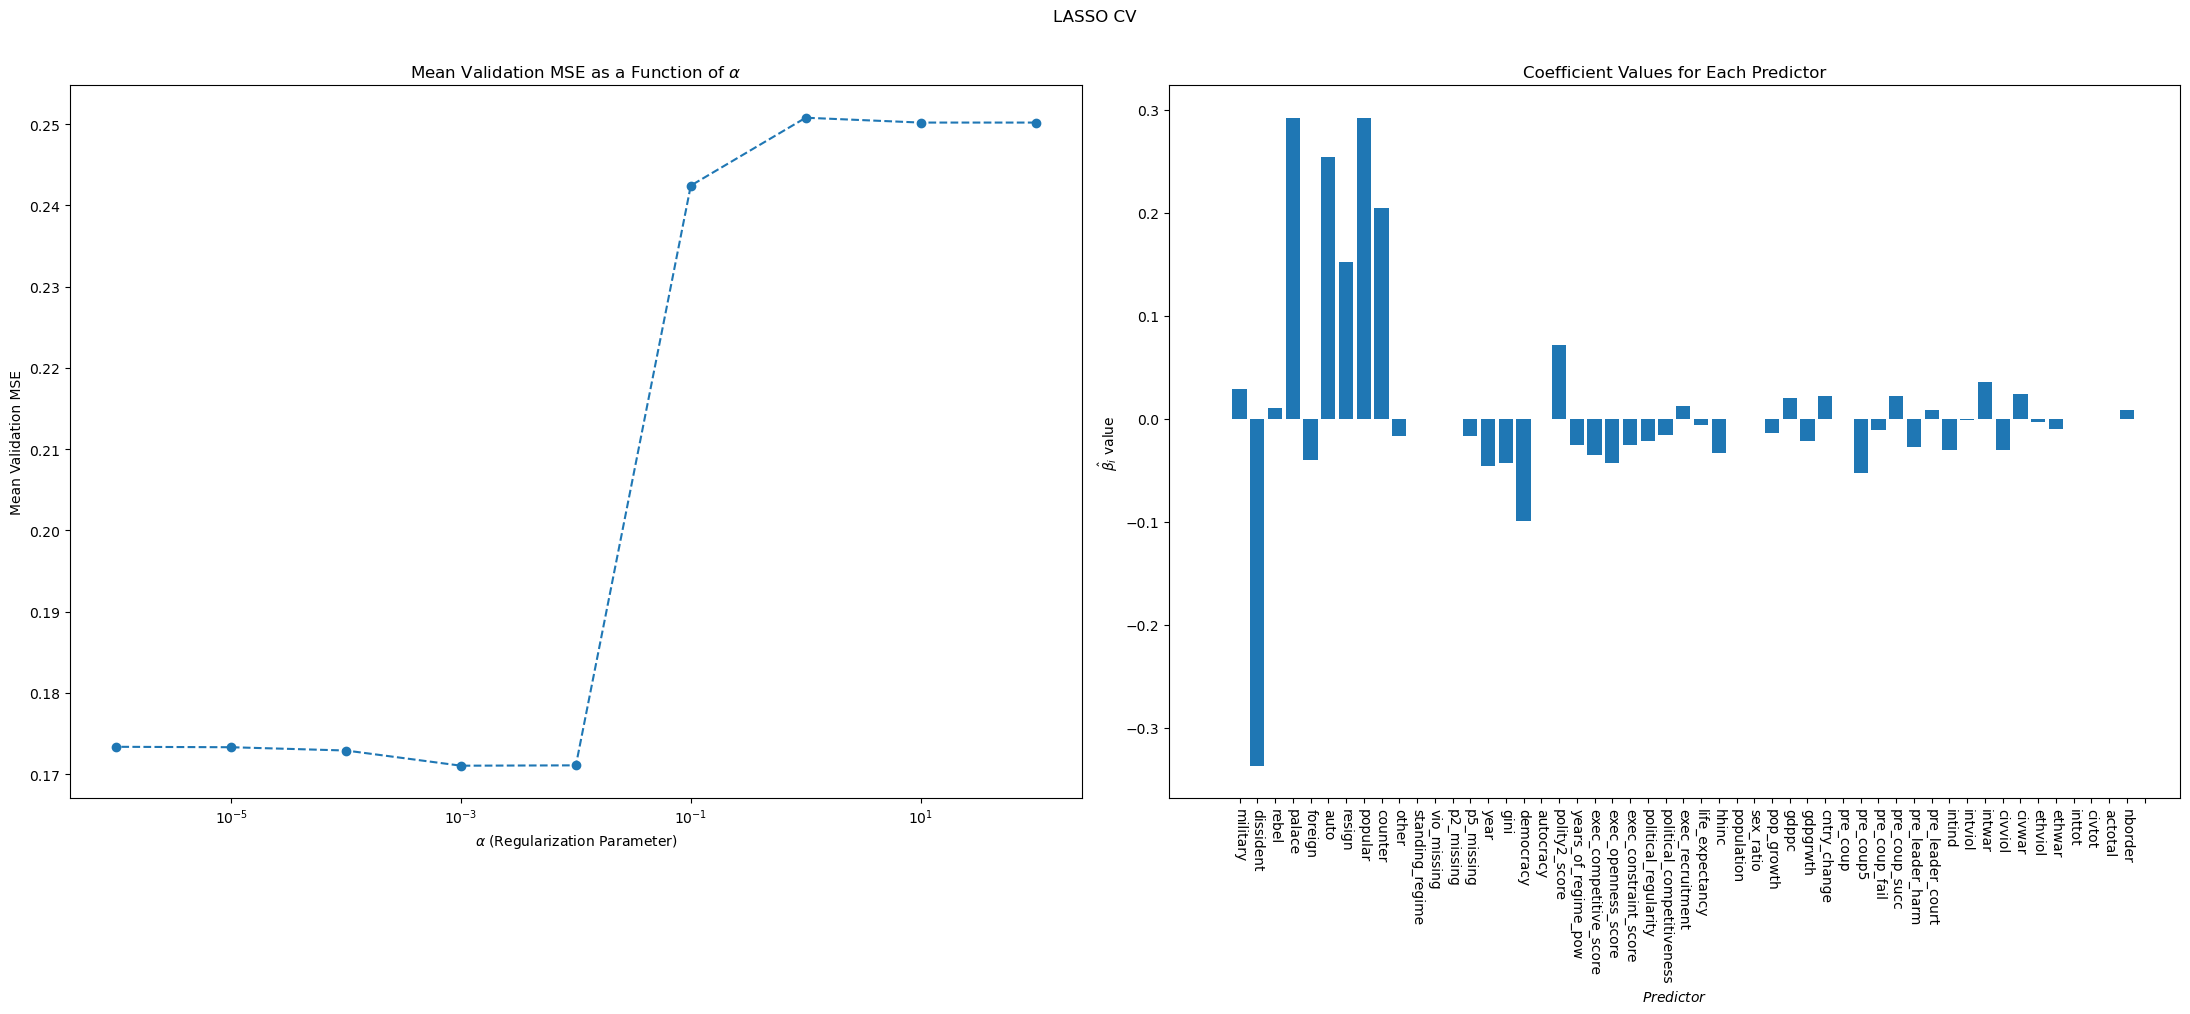

In [44]:
def plot_lasso1(lasso, lassoCV_val_mses_mean, x_train80):
  fig, axes = plt.subplots(1,2, figsize=(22,10))
  axes[0].plot(lasso.alphas_, lassoCV_val_mses_mean, 'o--')
  axes[0].set(
      xlabel=r'$\alpha$ (Regularization Parameter)',
      ylabel='Mean Validation MSE',
      title=r'Mean Validation MSE as a Function of $\alpha$',
  )
  axes[0].set_xscale('log')
  axes[1].bar(x_train80.columns.tolist(), lasso.coef_)
  axes[1].set(
      title=r"Coefficient Values for Each Predictor",
      xlabel=r'$Predictor$',
      ylabel=r'$\hat{\beta_i}}$ value',
      xticks=(range(1,len(lasso.coef_)+1)),
  )
  plt.suptitle("LASSO CV", y=1.01)
  plt.xticks(rotation=-90)
  plt.tight_layout();

plot_lasso1(lasso, lassoCV_val_mses_mean, x_train80)

In [45]:
def sig_features1_fxn(lasso, x_train80):
  coefs = lasso.coef_
  coefs2 = np.abs(coefs) > 0.01
  sig_features = []
  for i in range(len(coefs)):
      if coefs2[i] == True:
          sig_features.append(x_train80.columns[i])  
  return sig_features

sig_features = sig_features1_fxn(lasso, x_train80)

In [46]:
def boot_lasso1(x_train80, y_train80, max_degree=2, max_iter=1000):
  # Set bootstrapping parameters
  numboot = 100

  # Create empty dictionary for storing results
  significant_preds = {}

  # Perform bootstraps
  df_train = x_train80
  df_train['realized'] = y_train80
  for i in range(numboot):
      df_boot = df_train.sample(frac=1, replace=True)
      x_train_boot = df_boot[sig_features]


      y_train_boot = df_boot['realized']

      lasso = Lasso(
          fit_intercept=fit_intercept,
          max_iter=max_iter,
          alpha=best_alpha,
      )

      feature_names = sig_features

      lasso.fit(x_train_boot, y_train_boot)
      
      coefficients = lasso.coef_
      
      for i in np.where(np.abs(coefficients)>0.1)[0]:
          if feature_names[i] not in significant_preds.keys():
              significant_preds[feature_names[i]]=1
          else:
              significant_preds[feature_names[i]]+=1
              
  return significant_preds

significant_preds = boot_lasso1(x_train80, y_train80, max_degree=2, max_iter=1000)


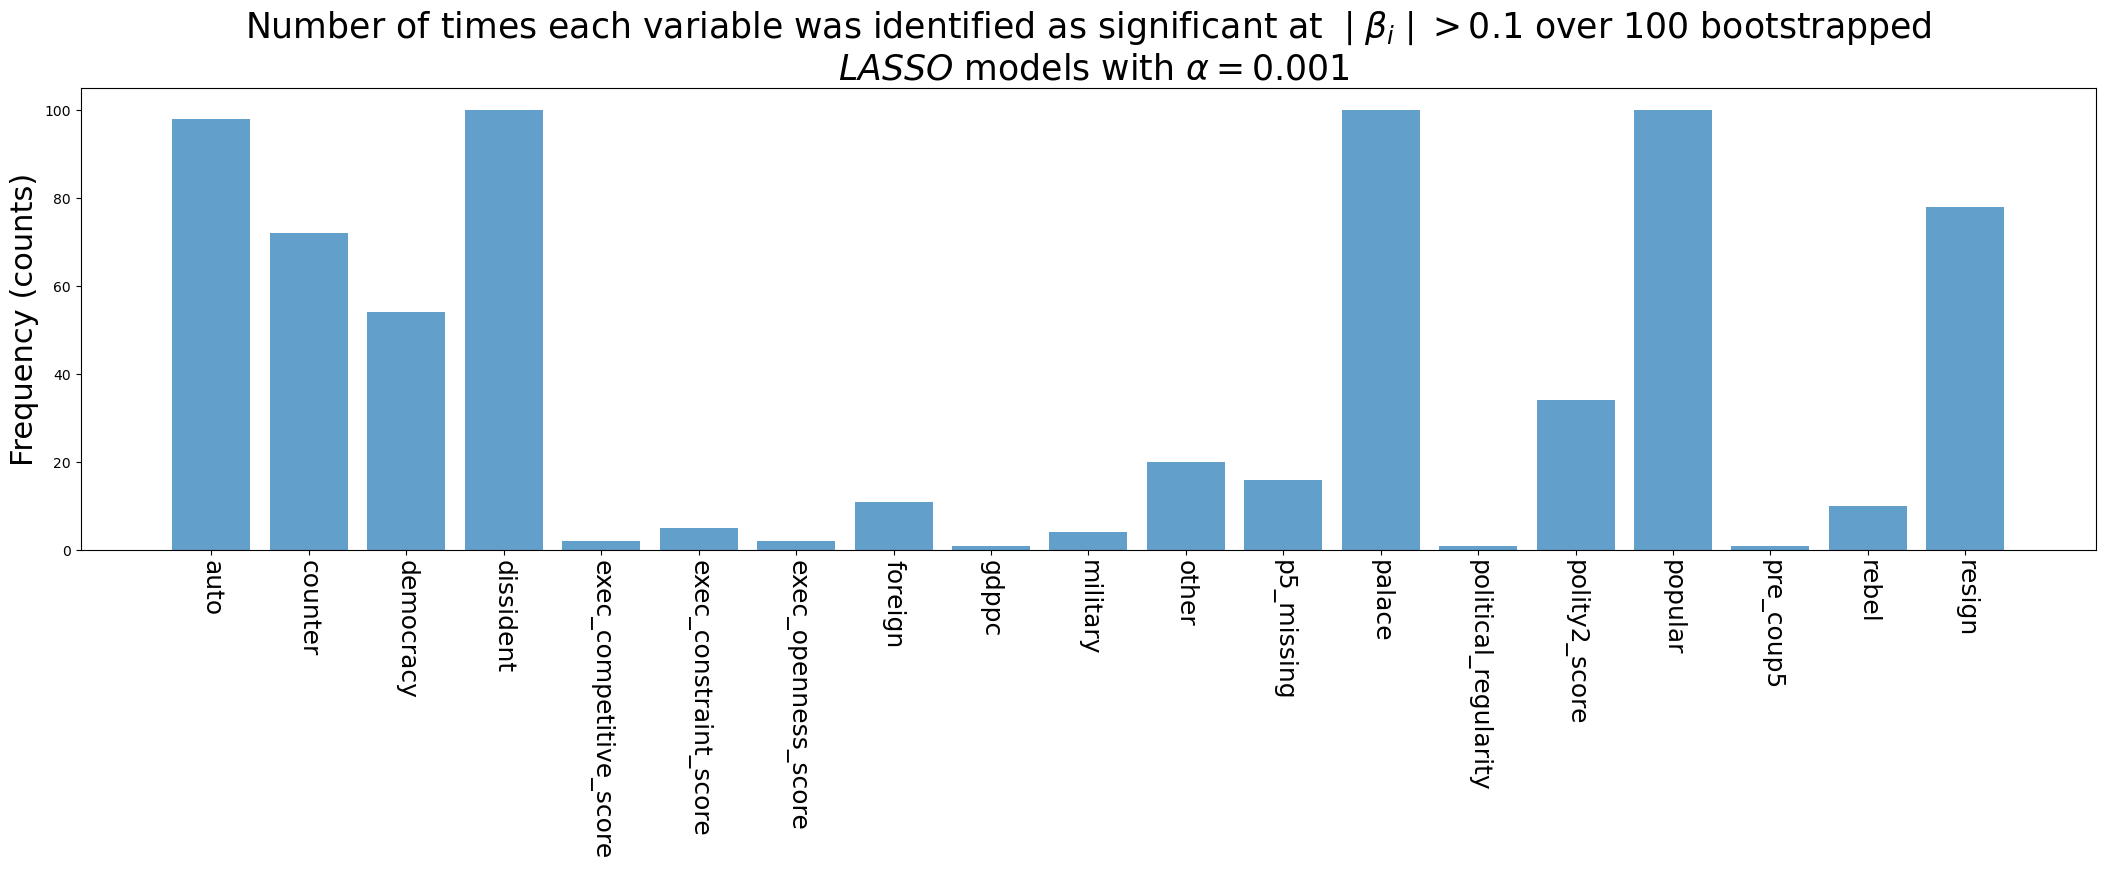

In [47]:
def plot_freqs(significant_preds, best_alpha, numboot=100):
  lists = sorted(significant_preds.items())

  x, y = zip(*lists)

  plt.figure(figsize=(26,6))

  plt.bar(x, y, alpha=0.7)
  plt.ylabel("Frequency (counts)", fontsize=22)
  plt.title(f"Number of times each variable was identified as significant at $\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped\n $LASSO$ models "
      f"with $\\alpha={best_alpha}$",
      fontsize=25,
  )
  plt.xticks(rotation=-90, fontsize=18);
  return

plot_freqs(significant_preds, best_alpha, numboot=100)


In [48]:
def round2_lasso(significant_preds, x_train80, y_train80, x_val, y_val, best_alpha, max_iter=10000):
  best_deg = 2

  good_cols = [x for x in significant_preds.keys() if significant_preds[x] > 20]

  #Compute the polynomial features for best degree
  p = PolynomialFeatures(
      best_deg, include_bias=False
  )

  x_poly_train = p.fit_transform(x_train80[good_cols])

  polycols = p.get_feature_names_out()

  x_poly_val = p.transform(x_val[good_cols])

  # Fit a linear regression model
  lasso = Lasso(
      max_iter=max_iter,
      alpha = best_alpha,
      fit_intercept=fit_intercept,
  )

  lasso.fit(x_poly_train, y_train80)

  y_train_pred = lasso.predict(x_poly_train)

  y_val_pred = lasso.predict(x_poly_val)

  print("Training MSE: ", mean_squared_error(y_train80, y_train_pred))
  print("Validation MSE: ", mean_squared_error(y_val, y_val_pred), "\n")

  # Generate predictions w/ caps on 1 and 0
  y_val_pred[y_val_pred >= .5] = 1
  y_val_pred[y_val_pred < .5] = 0
  y_train_pred[y_train_pred >= .5] = 1
  y_train_pred[y_train_pred < .5] = 0

  print("Training Accuracy: ", accuracy_score(y_train80, y_train_pred))
  print("Validation Accuracy: ", accuracy_score(y_val_pred, y_val))
  return good_cols, polycols, lasso

good_cols, polycols, lasso = round2_lasso(significant_preds, x_train80, y_train80, x_val, y_val, best_alpha, max_iter=10000)


Training MSE:  0.15308950760072568
Validation MSE:  0.16040515100766936 

Training Accuracy:  0.7562189054726368
Validation Accuracy:  0.7350993377483444


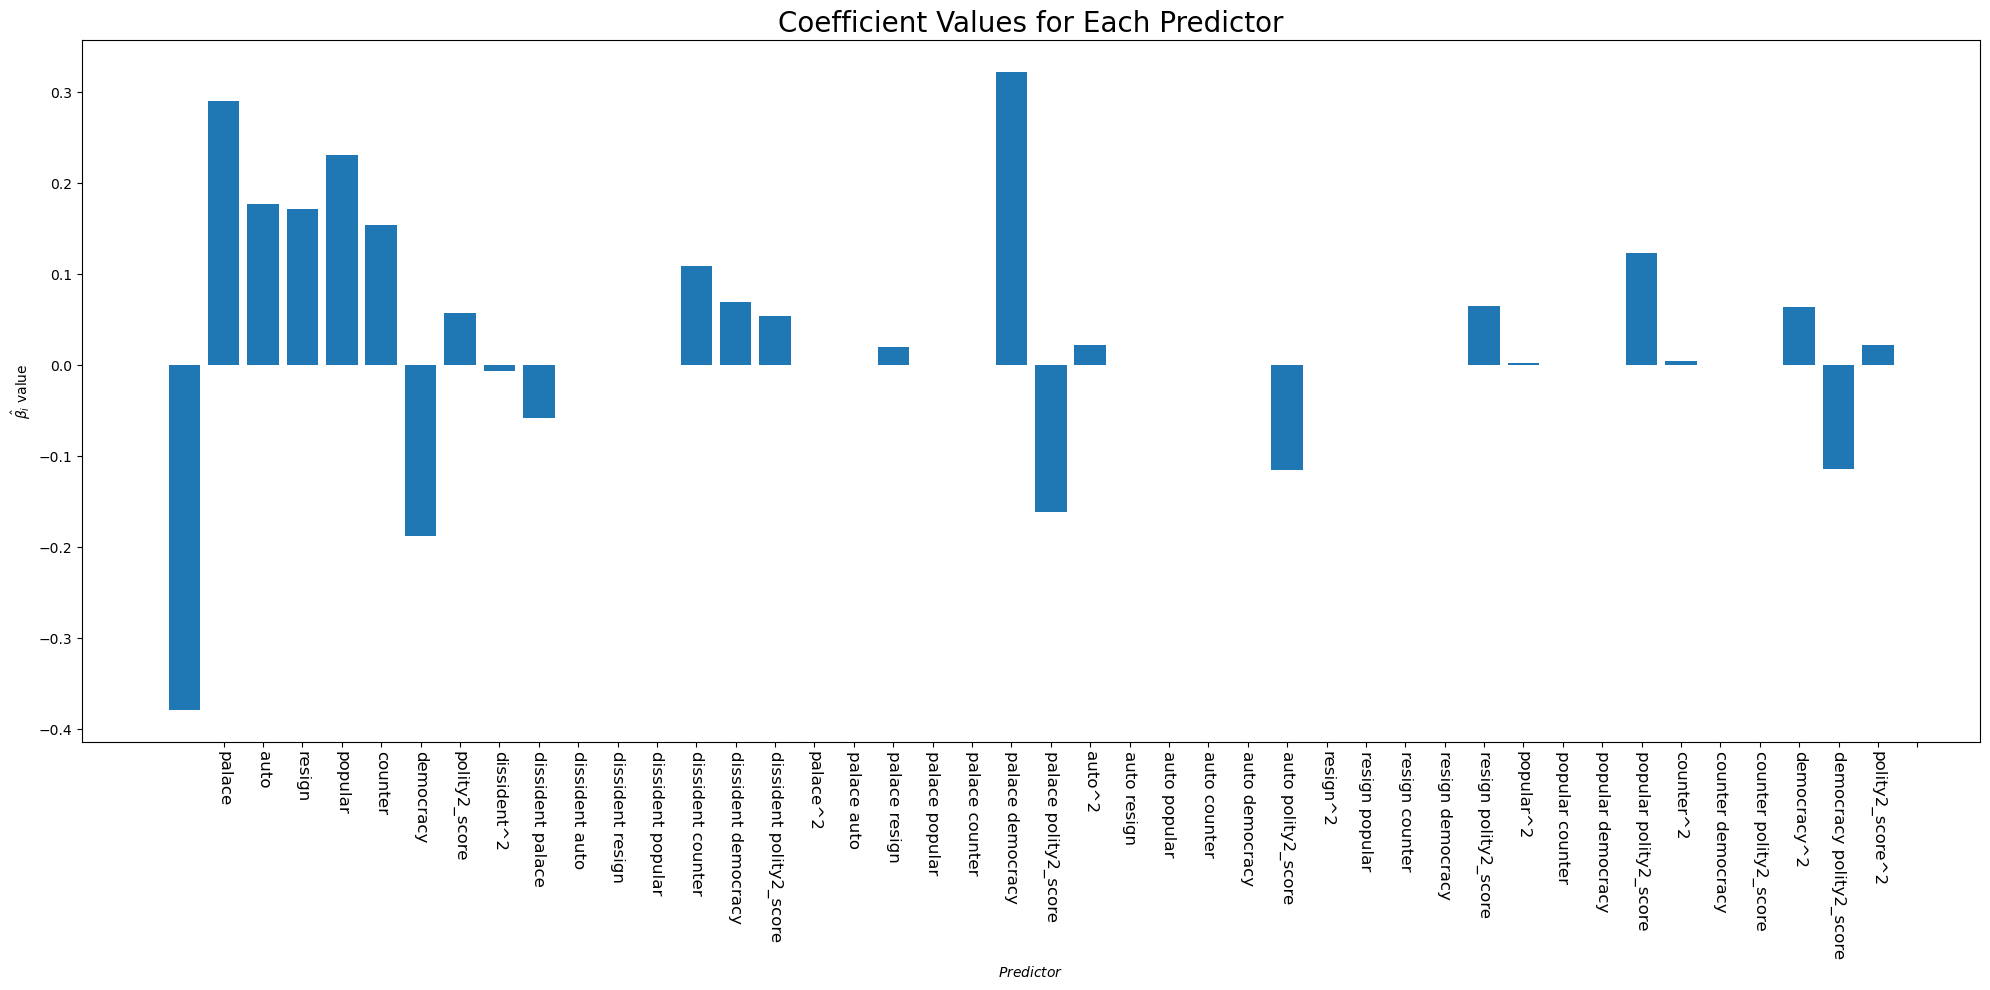

In [49]:
def plot_preds(polycols):
  plt.figure(figsize=(20,10))
  ax = plt.axes()
  plt.sca(ax)
  plt.bar(polycols, lasso.coef_)
  plt.title(r"Coefficient Values for Each Predictor", fontsize=20)
  plt.xlabel(r'$Predictor$')
  plt.ylabel(r'$\hat{\beta_i}}$ value')
  plt.xticks(range(1,len(lasso.coef_)+1))
  plt.xticks(rotation=-90, fontsize=12)
  plt.tight_layout();
  return

plot_preds(polycols)

In [50]:
def sig_features2_fxn(lasso, polycols):
  coefs = lasso.coef_
  coefs2 = np.abs(coefs) > 0.01
  sig_features2 = []
  for i in range(len(coefs)):
      if coefs2[i] == True:
          sig_features2.append(polycols[i]) 
  return sig_features2

sig_features2 = sig_features2_fxn(lasso, polycols)

In [51]:
def boot_lasso_2(x_train80, y_train80, x_val, y_val, good_cols, sig_features2, max_iter=10000):
  # Set bootstrapping parameters
  numboot = 100

  warnings.simplefilter('ignore', category=SettingWithCopyWarning)

  # Create empty dictionary for storing results
  significant_preds2 = {}

  # Perform bootstraps
  df_train = x_train80[good_cols]
  df_train['realized'] = y_train80
  for i in range(numboot):
      df_boot = df_train.sample(frac=1, replace=True)
      x_train_boot = df_boot

      y_train_boot = df_boot['realized']
      x_train_boot = x_train_boot.drop(['realized'], axis=1)[good_cols]

      poly = PolynomialFeatures(2, include_bias=include_bias)
      x_poly_train = poly.fit_transform(x_train_boot)
      x_poly_val = poly.transform(x_val[good_cols])

      feature_names = poly.get_feature_names_out()

      #subset on RELEVANT polynomial features
      x_poly_train = pd.DataFrame(x_poly_train, columns=feature_names)
      x_poly_val = pd.DataFrame(x_poly_val, columns=feature_names)
      x_poly_train_sub = x_poly_train[sig_features2]
      x_poly_val_sub = x_poly_val[sig_features2]

      lasso = Lasso(
          fit_intercept=fit_intercept,
          max_iter=max_iter,
          alpha=best_alpha,
      )

      feature_names2 = sig_features2

      lasso.fit(x_poly_train_sub, y_train_boot)
      
      coefficients = lasso.coef_
      
      for i in np.where(np.abs(coefficients)>0.1)[0]:
          if feature_names2[i] not in significant_preds2.keys():
              significant_preds2[feature_names2[i]]=1
          else:
              significant_preds2[feature_names2[i]]+=1

  return significant_preds2

significant_preds2 = boot_lasso_2(x_train80, y_train80, x_val, y_val, good_cols, sig_features2, max_iter=10000)

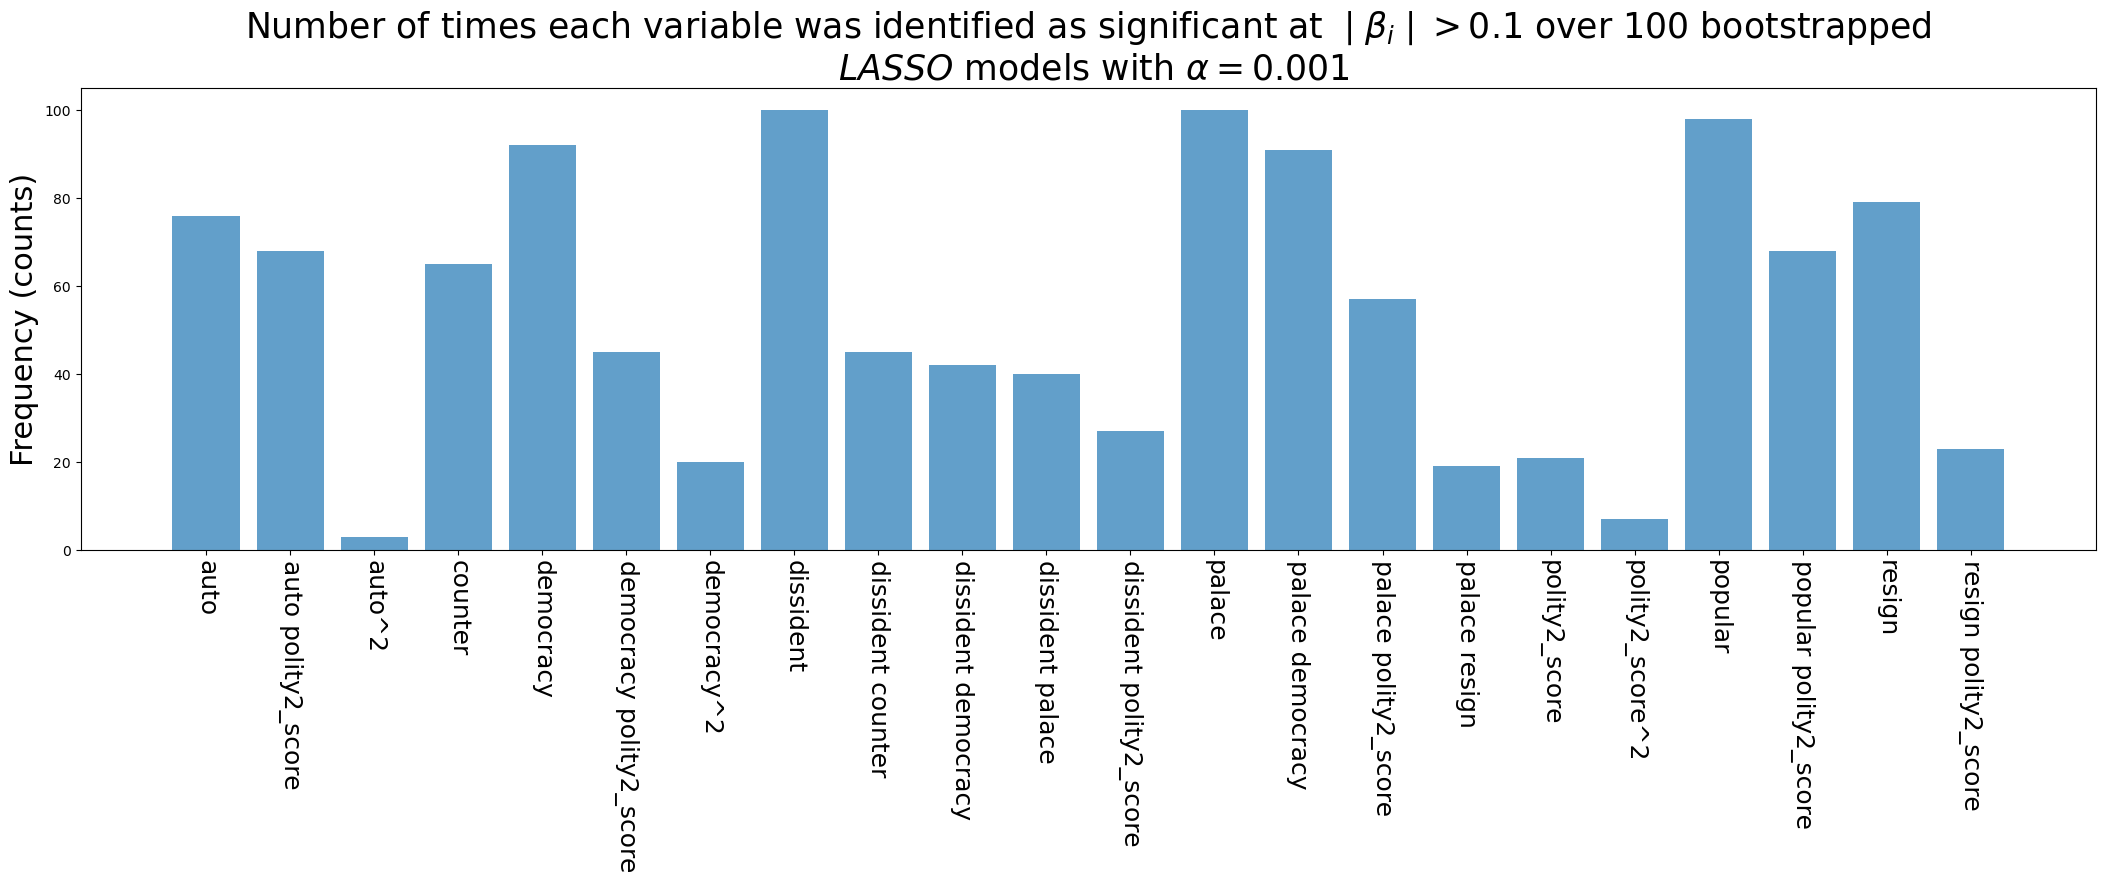

In [52]:
plot_freqs(significant_preds2, best_alpha)

In [53]:
def last_lasso(significant_preds2, X_train, y_train, X_test, y_test, max_iter=10000):
  good_cols2 = [x for x in significant_preds2.keys() if significant_preds2[x] >= 20]

  poly = PolynomialFeatures(degree=2)
  X_train = poly.fit_transform(X_train)
  X_test = poly.transform(X_test)
  X_train = pd.DataFrame(X_train, columns=poly.get_feature_names_out())
  X_test = pd.DataFrame(X_test, columns=poly.get_feature_names_out())

  X_train = X_train[[x for x in good_cols2]]
  X_test = X_test[[x for x in good_cols2]]

  lasso = Lasso(
          fit_intercept=fit_intercept,
          max_iter=max_iter,
          alpha=best_alpha,
      )

  lasso.fit(X_train, y_train)
  y_train_pred = lasso.predict(X_train)
  y_test_pred = lasso.predict(X_test)

  print("Training MSE: ", mean_squared_error(y_train, y_train_pred))
  print("Test MSE: ", mean_squared_error(y_test_pred, y_test), "\n")

  # Generate predictions w/ caps on 1 and 0
  y_test_pred[y_test_pred >= .5] = 1
  y_test_pred[y_test_pred < .5] = 0
  y_train_pred[y_train_pred >= .5] = 1
  y_train_pred[y_train_pred < .5] = 0

  print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
  print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
  return
last_lasso(significant_preds2, X_train, y_train, X_test, y_test, max_iter=10000)

Training MSE:  0.15356981506638856
Test MSE:  0.1539930057451661 

Training Accuracy:  0.7652519893899205
Test Accuracy:  0.7407407407407407


#### Using Dataset without Missingnesss

In [64]:
cols = ['year', 'conspiracy', 'attempt', 'military', 'dissident', 'rebel', 'palace',
        'foreign', 'auto', 'popular', 'counter', 'other', 'region', 'sub-region']

binaries = ['military', 'dissident', 'rebel', 'palace', 'foreign', 'auto', 'resign', 'popular', 'counter', 'other']   

indicators = ['coup_id', 'cowcode', 'country']

categoricals = []

numericals = ['year']

make_design_matrix(data_2, numericals, categoricals, binaries, indicators, cols)

(['military',
  'dissident',
  'rebel',
  'palace',
  'foreign',
  'auto',
  'resign',
  'popular',
  'counter',
  'other'],
 ['year'],
 [])

In [65]:
X, y, X_train, X_test, y_train, y_test = split()

(943, 16)


In [66]:
x_train80, x_val, y_train80, y_val = split_further(X_train, y_train)

In [67]:
lasso, lassoCV_val_mses_mean, lassoCV_val_mses_std, best_alpha = round1_lasso(x_train80, y_train80)

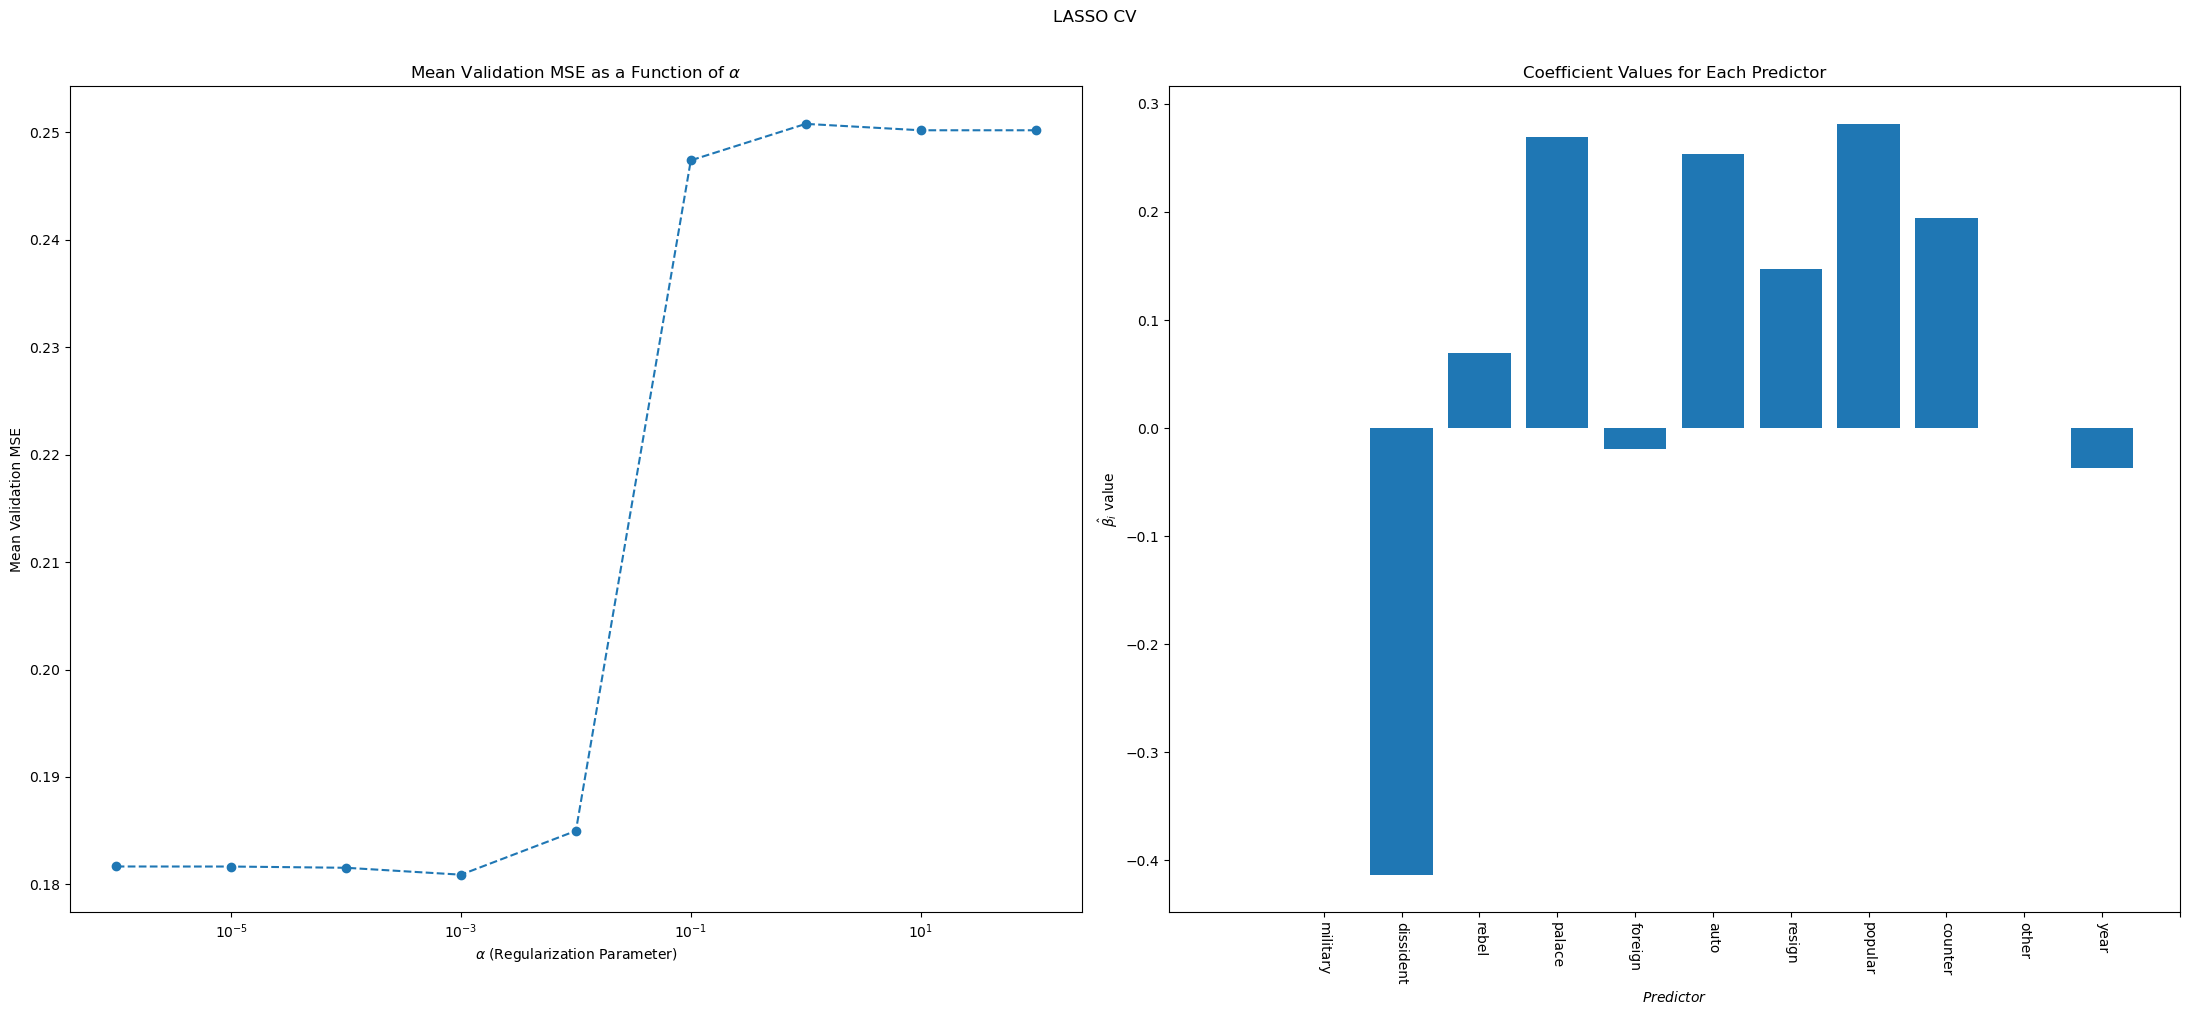

In [68]:
plot_lasso1(lasso, lassoCV_val_mses_mean, x_train80)

In [69]:
sig_features = sig_features1_fxn(lasso, x_train80)

In [70]:
significant_preds = boot_lasso1(x_train80, y_train80, max_degree=2, max_iter=1000)

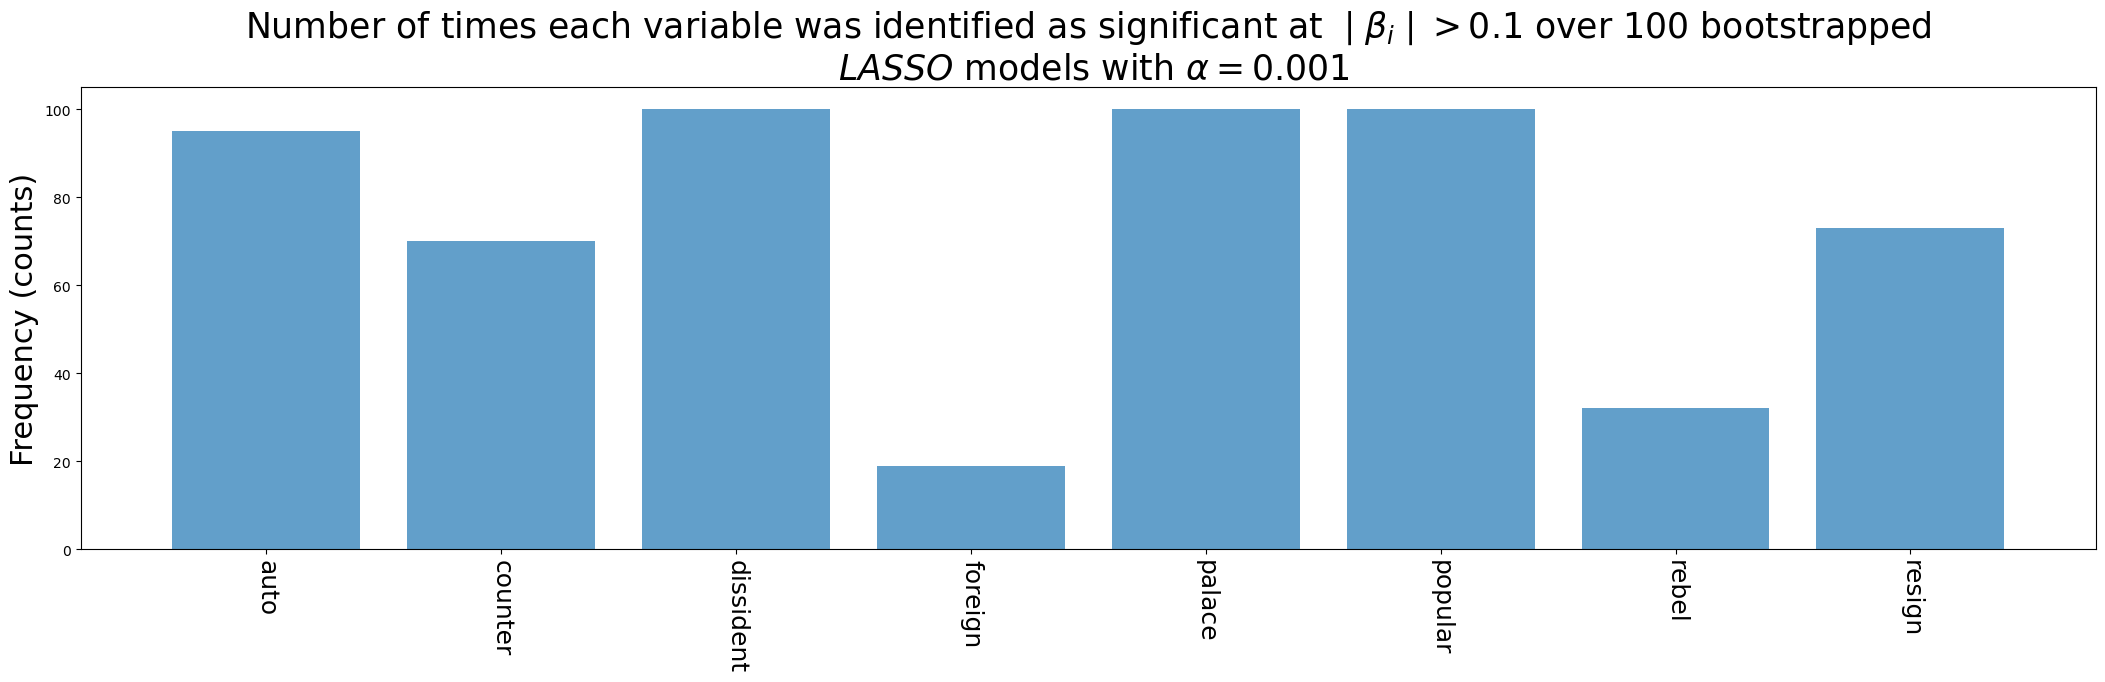

In [71]:
plot_freqs(significant_preds, best_alpha, numboot=100)

In [72]:
good_cols, polycols, lasso = round2_lasso(significant_preds, x_train80, y_train80, x_val, y_val, best_alpha, max_iter=10000)


Training MSE:  0.17365675950883
Validation MSE:  0.15092418446924236 

Training Accuracy:  0.7164179104477612
Validation Accuracy:  0.7880794701986755


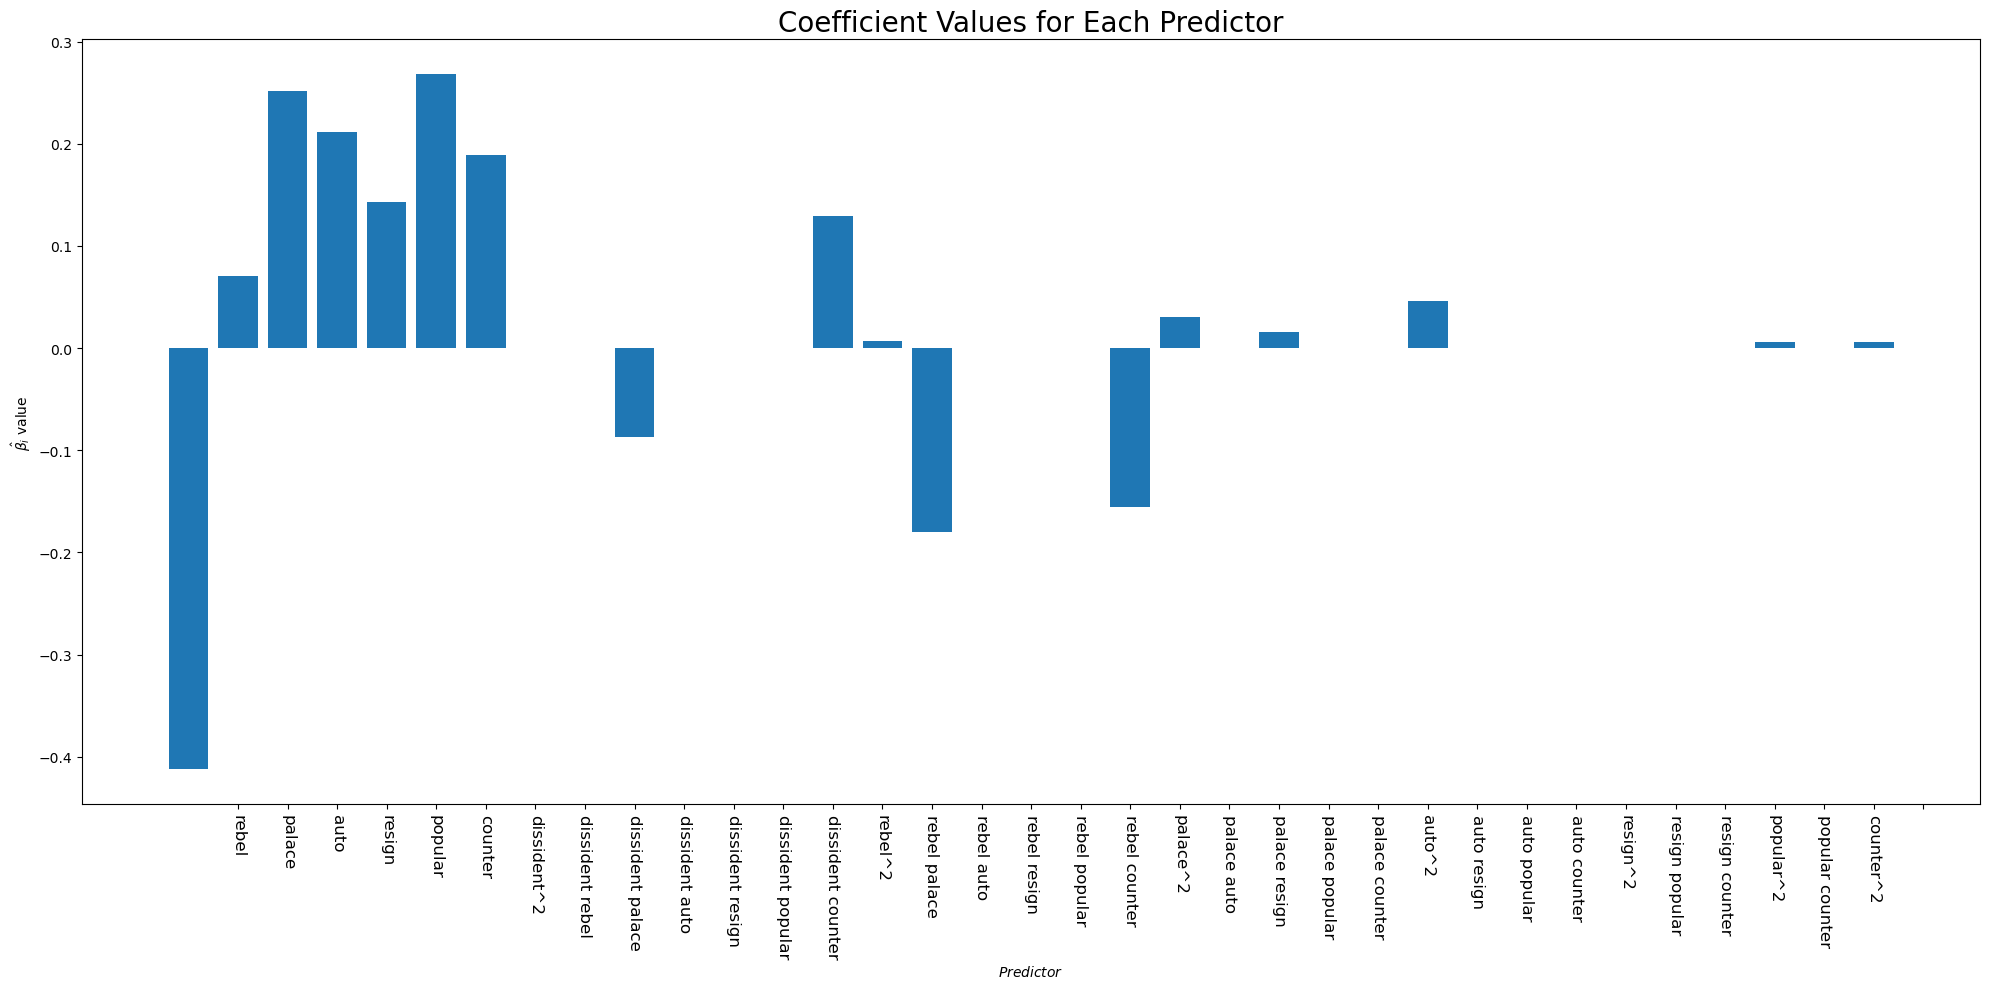

In [73]:
plot_preds(polycols)

In [74]:
sig_features2 = sig_features2_fxn(lasso, polycols)

In [75]:
significant_preds2 = boot_lasso_2(x_train80, y_train80, x_val, y_val, good_cols, sig_features2, max_iter=10000)

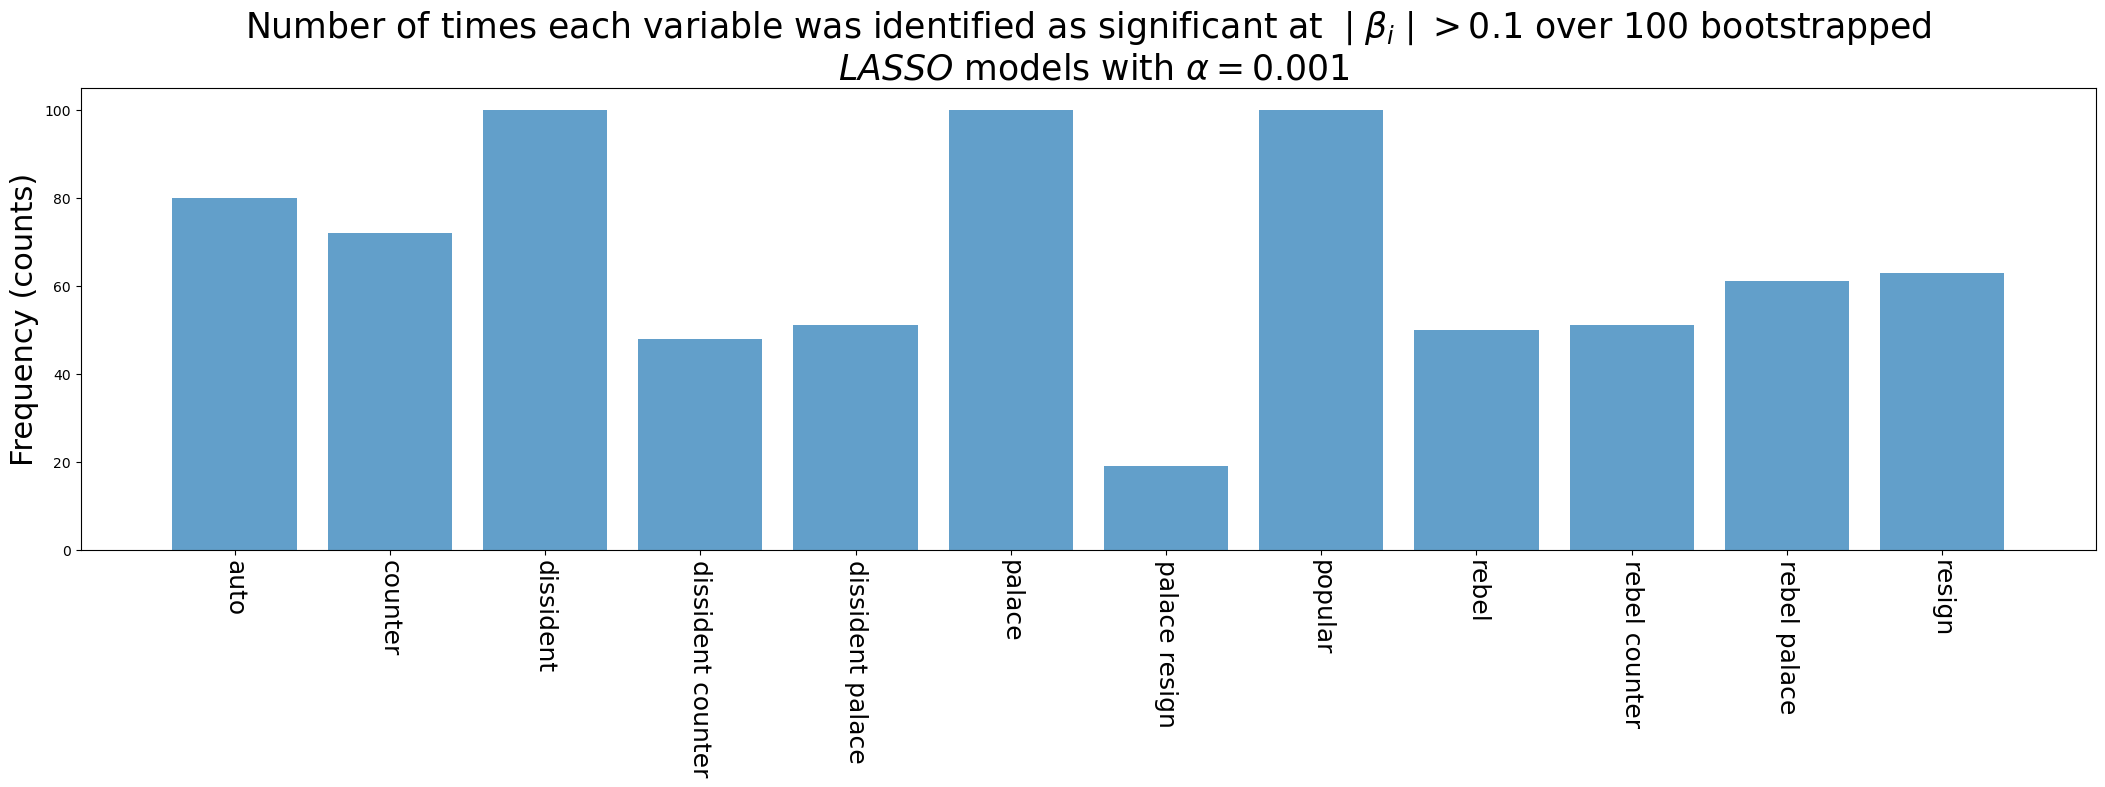

In [76]:
plot_freqs(significant_preds2, best_alpha)

In [77]:
last_lasso(significant_preds2, X_train, y_train, X_test, y_test, max_iter=10000)

Training MSE:  0.16868738433935995
Test MSE:  0.15924299540319833 

Training Accuracy:  0.7307692307692307
Test Accuracy:  0.7619047619047619


In [78]:
x = data_1.drop(["coup_id","cowcode","country","event_type","realized","unrealized"],1)
y = data_1.realized
x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.2, random_state=1
)

C:\Users\angle\AppData\Local\Temp\ipykernel_18988\2151110782.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = data_1.drop(["coup_id","cowcode","country","event_type","realized","unrealized"],1)


In [79]:
x_imp = data_2.drop(["coup_id","cowcode","country","event_type","realized","unrealized"],1)
y_imp = data_2.realized
x_train_imp, x_test_imp, y_train_imp, y_test_imp = train_test_split(
    x_imp, y_imp, test_size=0.2, random_state=1
)

C:\Users\angle\AppData\Local\Temp\ipykernel_18988\2681377822.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_imp = data_2.drop(["coup_id","cowcode","country","event_type","realized","unrealized"],1)


# Random Forest

## No Political Data

**Find max depth that will overfit on the training data**

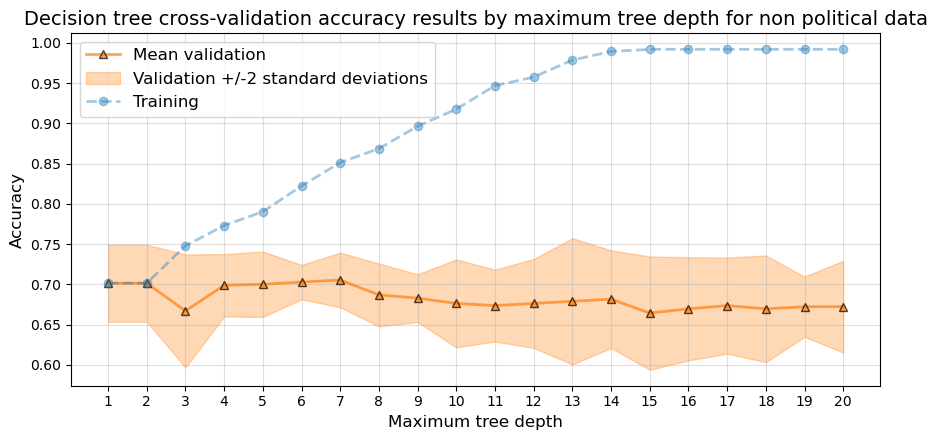

In [80]:

def calc_meanstd(x_train, y_train, depths, cv):
    cvmeans = []
    cvstds = []
    train_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        # calculate training score and save to list
        train_scores.append(clf.fit(x_train, y_train).score(x_train, y_train))
        # perform 5-fold CV and save mean and std to lists
        scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=cv)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    return cvmeans, cvstds, train_scores


def plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
):
    plt.figure(figsize=(9, 4.5))
    plt.plot(
        depths,
        cvmeans,
        "^-",
        label="Mean validation",
        markeredgecolor="k",
        color="tab:orange",
        alpha=0.7,
        linewidth=2,
    )
    plt.fill_between(
        depths,
        cvmeans - 2*cvstds,
        cvmeans + 2*cvstds,
        color="tab:orange",
        alpha=0.3,
        label="Validation +/-2 standard deviations",
    )
    
    if limit_y:
        ylim = plt.ylim()
        plt.ylim(ylim)
    
    plt.plot(
        depths,
        train_scores,
        "o--",
        label="Training",
        color="tab:blue",
        alpha=0.4,
        linewidth=2,
    )

    if show_legend:
        plt.legend(fontsize=12)
    
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel("Maximum tree depth", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(depths)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

# set parameters for model fitting
depths = list(range(1, 21))
cv = 5

# perform CV and generate required results
cvmeans, cvstds, train_scores = calc_meanstd(
    x_train, y_train, depths, cv
)

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plot results as full plot
title = (
    "Decision tree cross-validation accuracy results by "
    "maximum tree depth for non political data"
)
plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
)

# plot results with limited y-axis as required
title = (
    "Detailed view of results to illustrate validation trend"
)

_We selected a max depth of 16 because of the values that overfit to the train data (16-20), 16 has a relatively high validation score while still maintaing a similar train accuracy score._

In [81]:
tree_depth = 16
n_trees = 200
# fit random forest as required
fitted_rf = RandomForestClassifier(
    n_estimators=n_trees, max_features="sqrt", max_depth=tree_depth, random_state=1
).fit(x_train,y_train)

# evaluate results
random_forest_train_score = fitted_rf.score(x_train, y_train) # SOLUTION
random_forest_test_score = fitted_rf.score(x_test, y_test) # SOLUTION

# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-16 and 200 trees achieves the following accuracy scores:

	train	0.9920
	TEST	0.6931


In [82]:
perm = PermutationImportance(fitted_rf,random_state=1,n_iter=10).fit(x_test, y_test)
eli5.show_weights(perm,feature_names=x.columns.tolist())

Weight,Feature
0.1540 ± 0.0261,dissident
0.0196 ± 0.0126,popular
0.0185 ± 0.0185,year
0.0148 ± 0.0156,life_expectancy
0.0122 ± 0.0126,military
0.0106 ± 0.0047,pre_coup_succ
0.0106 ± 0.0157,standing_regime
0.0101 ± 0.0110,pre_leader_harm
0.0095 ± 0.0182,gdpgrwth
0.0095 ± 0.0079,pre_leader_court


## Political Data (Imputation)

**Find max depth that will overfit on the training data**

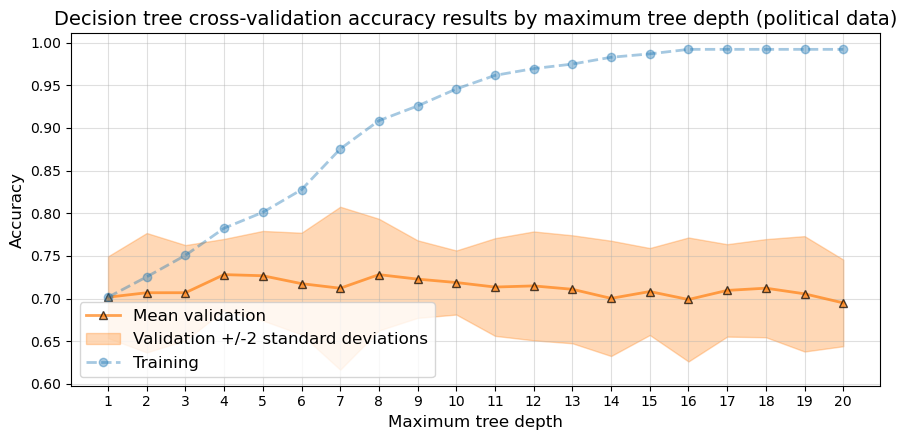

In [83]:

def calc_meanstd(x_train_imp, y_train_imp, depths, cv):
    cvmeans = []
    cvstds = []
    train_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        # calculate training score and save to list
        train_scores.append(clf.fit(x_train_imp, y_train_imp).score(x_train_imp, y_train_imp))
        # perform 5-fold CV and save mean and std to lists
        scores = cross_val_score(estimator=clf, X=x_train_imp, y=y_train_imp, cv=cv)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    return cvmeans, cvstds, train_scores


def plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
):
    plt.figure(figsize=(9, 4.5))
    plt.plot(
        depths,
        cvmeans,
        "^-",
        label="Mean validation",
        markeredgecolor="k",
        color="tab:orange",
        alpha=0.7,
        linewidth=2,
    )
    plt.fill_between(
        depths,
        cvmeans - 2*cvstds,
        cvmeans + 2*cvstds,
        color="tab:orange",
        alpha=0.3,
        label="Validation +/-2 standard deviations",
    )
    
    if limit_y:
        ylim = plt.ylim()
        plt.ylim(ylim)
    
    plt.plot(
        depths,
        train_scores,
        "o--",
        label="Training",
        color="tab:blue",
        alpha=0.4,
        linewidth=2,
    )

    if show_legend:
        plt.legend(fontsize=12)
    
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel("Maximum tree depth", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(depths)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

# set parameters for model fitting
depths = list(range(1, 21))
cv = 5

# perform CV and generate required results
cvmeans, cvstds, train_scores = calc_meanstd(
    x_train_imp, y_train_imp, depths, cv
)

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plot results as full plot
title = (
    "Decision tree cross-validation accuracy results by "
    "maximum tree depth (political data)"
)
plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
)

# plot results with limited y-axis as required
title = (
    "Detailed view of results to illustrate validation trend"
)

_We selected a max depth of 20 because of the values that overfit to the train data (16-20), 20 has a relatively high validation score and the highest train score._

In [84]:
tree_depth = 20
n_trees = 200
# fit random forest as required
fitted_rf = RandomForestClassifier(
    n_estimators=n_trees, max_features="sqrt", max_depth=tree_depth, random_state=1
).fit(x_train_imp,y_train_imp)

# evaluate results
random_forest_train_score = fitted_rf.score(x_train_imp, y_train_imp) # SOLUTION
random_forest_test_score = fitted_rf.score(x_test_imp, y_test_imp) # SOLUTION

# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-20 and 200 trees achieves the following accuracy scores:

	train	0.9920
	TEST	0.7513


In [85]:
perm = PermutationImportance(fitted_rf,random_state=1,n_iter=10).fit(x_test_imp, y_test_imp)
eli5.show_weights(perm,feature_names=x_imp.columns.tolist())

Weight,Feature
0.1397 ± 0.0339,dissident
0.0280 ± 0.0348,years_of_regime_pow
0.0106 ± 0.0106,pop_growth
0.0063 ± 0.0104,military
0.0053 ± 0.0047,auto
0.0048 ± 0.0032,pre_leader_harm
0.0037 ± 0.0083,civwar
0.0032 ± 0.0108,gdpgrwth
0.0011 ± 0.0092,palace
0 ± 0.0000,Sub-Saharan Africa


# AdaBoost

## No political data

In [86]:
x_train80, x_val, y_train80, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=1
)

In [ ]:
np.random.seed(1)
depths = [1, 2, 3, 4,5,6]
n_estimators = 800
learning_rate = 0.05

train_scores = {}
val_scores = {}

# fit classifiers and generate staged scores at each depth
for max_depth in depths:
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        learning_rate=learning_rate,
    ).fit(x_train80, y_train80)
    
    train_scores[max_depth] = list(
        fitted_ada.staged_score(x_train80, y_train80)
    )
    val_scores[max_depth] = list(
        fitted_ada.staged_score(x_val, y_val)
    )


fig, axs = plt.subplots(1, len(depths), figsize=(9, 4.5), sharey=True)
for i, (ax, max_depth) in enumerate(zip(axs, depths)):
    ax.plot(train_scores[max_depth], "-", label="train", alpha=0.5)
    ax.plot(val_scores[max_depth], "-", label="validation", alpha=1)
    ax.set_xticks(np.arange(0, n_estimators+1, 100))
    ax.set_xticklabels(np.arange(0, n_estimators+1, 100), rotation=45)
    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_title(f"max_depth={max_depth}", fontsize=12)
    ax.grid(":", alpha=0.4)
    if i==0:
        ax.set_ylabel("Accuracy", fontsize=12)
        ax.legend(fontsize=12)
    
plt.suptitle(
    "Accuracy of AdaBoost as training progresses by iteration "
    "and max. tree depth",
    y=1,
    fontsize=14,
)
plt.tight_layout()

C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Your\Root\Prefix\envs\cs109a\lib\site-pack

In [ ]:
print("Max Test Accuracy Scores:")
for d in depths:
    max_accur = max(val_scores[d])
    iters = val_scores[d].index(max_accur) + 1
    print('depth-'+str(d)+": "+ str(max_accur)+ " (Interations: " + str(iters)+") ")

In [ ]:
best_max_depth = 4
best_n_estimators = 410
learning_rate = 0.05

final_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=best_max_depth),
    n_estimators=best_n_estimators,
    learning_rate=learning_rate,
).fit(x_train,y_train)

ada_train_acc = final_ada.score(x_train, y_train) 
ada_test_acc = final_ada.score(x_test, y_test) 

print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

In [ ]:
perm = PermutationImportance(final_ada,random_state=1,n_iter=10).fit(x_test, y_test)
eli5.show_weights(perm,feature_names=x.columns.tolist())

## Political Data (Imputation)

In [ ]:
x_imp = data_2.drop(["coup_id","cowcode","country","event_type","realized","unrealized"],1)
y_imp = data_2.realized
x_train, x_test, y_train, y_test = train_test_split(
    data_2.drop(["coup_id","cowcode","country","event_type","realized","unrealized"],1), data_2.realized, test_size=0.2, random_state=1
)

In [ ]:
x_train80, x_val, y_train80, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=1
)

In [ ]:
np.random.seed(1)
depths = [1, 2, 3, 4,5,6,7,8,9,10]
n_estimators = 800
learning_rate = 0.05

train_scores = {}
val_scores = {}

# fit classifiers and generate staged scores at each depth
for max_depth in depths:
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        learning_rate=learning_rate,
    ).fit(x_train80, y_train80)
    
    train_scores[max_depth] = list(
        fitted_ada.staged_score(x_train80, y_train80)
    )
    val_scores[max_depth] = list(
        fitted_ada.staged_score(x_val, y_val)
    )


fig, axs = plt.subplots(1, len(depths), figsize=(9, 4.5), sharey=True)
for i, (ax, max_depth) in enumerate(zip(axs, depths)):
    ax.plot(train_scores[max_depth], "-", label="train", alpha=0.5)
    ax.plot(val_scores[max_depth], "-", label="validation", alpha=1)
    ax.set_xticks(np.arange(0, n_estimators+1, 100))
    ax.set_xticklabels(np.arange(0, n_estimators+1, 100), rotation=45)
    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_title(f"max_depth={max_depth}", fontsize=12)
    ax.grid(":", alpha=0.4)
    if i==0:
        ax.set_ylabel("Accuracy", fontsize=12)
        ax.legend(fontsize=12)
    
plt.suptitle(
    "Accuracy of AdaBoost as training progresses by iteration "
    "and max. tree depth",
    y=1,
    fontsize=14,
)
plt.tight_layout()

In [ ]:
print("Max Test Accuracy Scores:")
for d in depths:
    max_accur = max(val_scores[d])
    iters = val_scores[d].index(max_accur) + 1
    print('depth-'+str(d)+": "+ str(max_accur)+ " (Interations: " + str(iters)+") ")

In [ ]:
best_max_depth = 5
best_n_estimators = 15
learning_rate = 0.05

final_ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=best_max_depth),
    n_estimators=best_n_estimators,
    learning_rate=learning_rate,
).fit(x_train,y_train)

ada_train_acc = final_ada.score(x_train, y_train) 
ada_test_acc = final_ada.score(x_test, y_test) 

print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

In [ ]:
perm = PermutationImportance(final_ada,random_state=1,n_iter=10).fit(x_test, y_test)
eli5.show_weights(perm,feature_names=x_imp.columns.tolist())